In [26]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [27]:
btc_data_path  = "data/BCHAIN-MKPRU_refine.csv"
gold_data_path = "data/LBMA-GOLD_refine.csv"

# Reading Data

In [28]:
btc_data  = pd.read_csv(btc_data_path).rename(columns={ 'Date': 'date', 'Value': 'btc' })
gold_data = pd.read_csv(gold_data_path).rename(columns={ 'Date': 'date', 'USD': 'gold' })

<AxesSubplot:xlabel='date'>

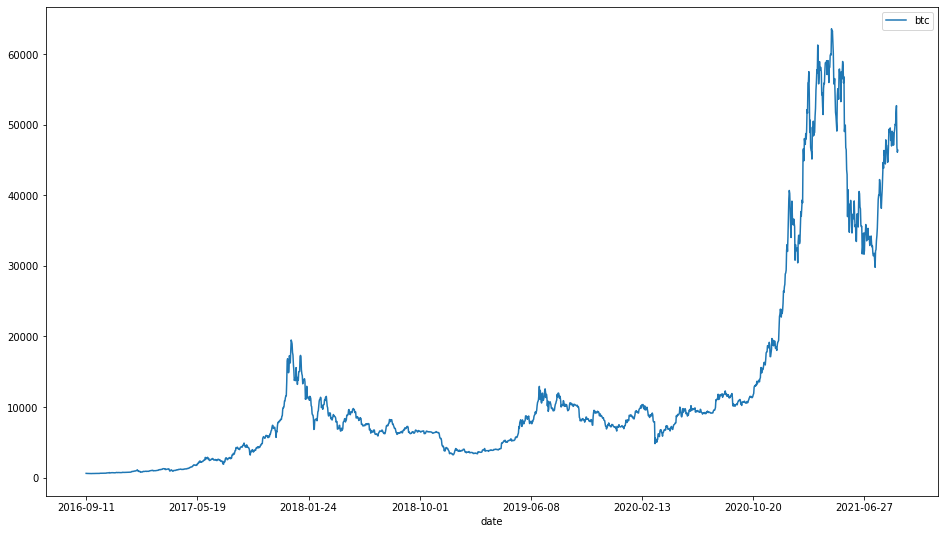

In [29]:
btc_data.set_index('date').plot(figsize=(16, 9))

<AxesSubplot:xlabel='date'>

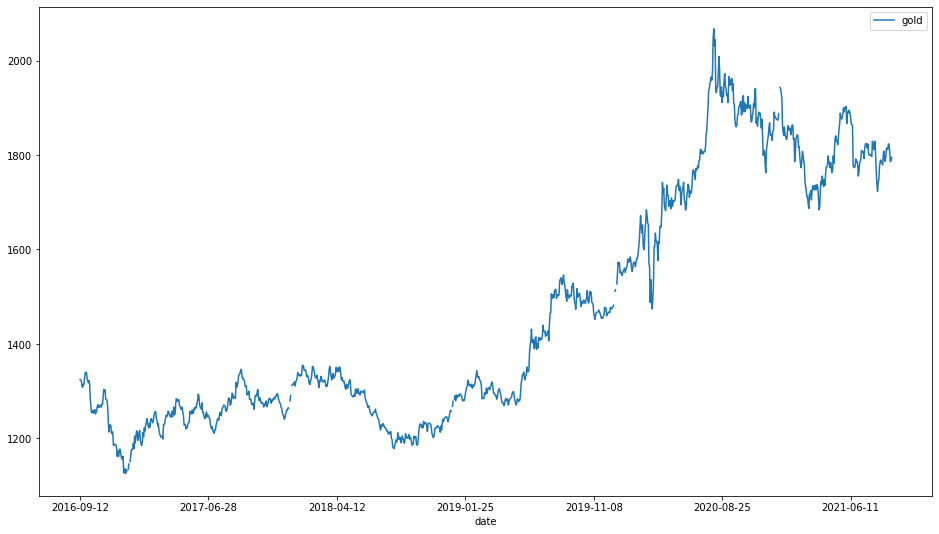

In [30]:
gold_data.set_index('date').plot(figsize=(16, 9))

# Data Processing

## Data Merge

In [53]:
data = pd.merge(left=btc_data, right=gold_data, how='left')
data.insert(data.shape[1], 'gold_tradable', ~np.asarray(data['gold'].isna()))

## Interpolation of Gold Prices

In [51]:
gold_inter = data.gold.interpolate(method='pad')
gold_inter[0] = gold_inter[1]

data.insert(data.shape[1] - 1, 'gold_inter', gold_inter)

## Setting Index

In [50]:
tdi = pd.DatetimeIndex(data.date)
data.set_index(tdi, inplace=True)
data.drop(columns=['date'], inplace=True)

,btc,gold,gold_inter,gold_tradable
date,,,,
2016-09-11,621.65,NaN,1324.60,False
2016-09-12,609.67,1324.60,1324.60,True
2016-09-13,610.92,1323.65,1323.65,True
2016-09-14,608.82,1321.75,1321.75,True
2016-09-15,610.38,1310.80,1310.80,True
...,...,...,...,...
2021-09-06,51769.06,1821.60,1821.60,True
2021-09-07,52677.40,1802.15,1802.15,True
2021-09-08,46809.17,1786.00,1786.00,True


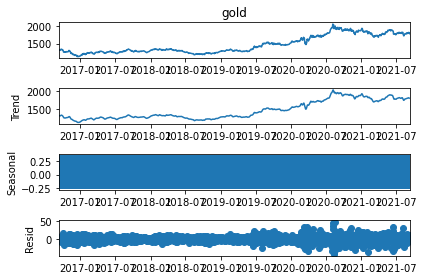

In [49]:
decomposed = sm.tsa.seasonal_decompose(gold_inter)
resplot = decomposed.plot()